# Time Series Forecasting using Prophet

This notebook uses Facebook Prophet Python API for time series forecasting and parameter tuning. I will creare an instance of Prophet classs and then call its fit and predict methods.

In [211]:
#import libraries
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from datetime import date

In [215]:
#import data
file_path = os.path.join(os.path.expanduser('~'),"AI Workflow Last Module AI in Prod","Capstone","data","cs-train","ts-data","ts-all.csv")
ts_all = pd.read_csv(file_path)

In [218]:
#check data infor
ts_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             607 non-null    object 
 1   purchases        607 non-null    int64  
 2   unique_invoices  607 non-null    int64  
 3   unique_streams   607 non-null    int64  
 4   total_views      607 non-null    int64  
 5   year_month       607 non-null    object 
 6   revenue          607 non-null    float64
dtypes: float64(1), int64(4), object(2)
memory usage: 33.3+ KB


In [180]:
#create a new dataframe with only date and revenue. We will use this dataframe for time series forecasting
ts_all_rev = pd.DataFrame(ts_eire.loc[:, ['date','revenue']])

In [181]:
#get the number of rows and columns in dataframe
ts_all_rev.shape

(607, 2)

In [219]:
#rename the columns to be able to use this dataframe for time series forecasting using Prophet
ts_all_rev.rename(columns = {'date':'ds','revenue':'y'}, inplace = True)

In [220]:
ts_all_rev.head()

,ds,y
0,2017-11-01,0.0
1,2017-11-02,0.0
2,2017-11-03,0.0
3,2017-11-04,0.0
4,2017-11-05,0.0


<Figure size 720x720 with 0 Axes>

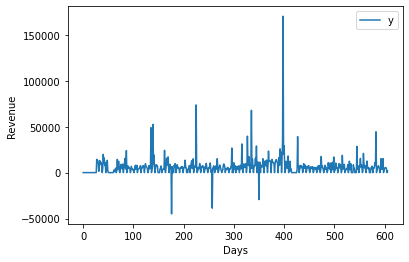

In [222]:
#plot time series data
plt.figure(figsize=(10,10))
ts_all_rev.plot()
plt.ylabel("Revenue")
plt.xlabel("Days")
plt.show()

Fit the model by instantiating a new Prophet object with no parameter

In [224]:
model1=Prophet()
model1.fit(ts_all_rev)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Create a dataframe that extends into the future a specified number of days using method Prophet.make_future_dataframes. Since, the requirement is to predict for next 30 days, hence I am using period=30

In [226]:
future = model1.make_future_dataframe(periods=30)
future.tail()

,ds
632,2019-07-26
633,2019-07-27
634,2019-07-28
635,2019-07-29
636,2019-07-30


Predict method assigns each row in future a predicted value which it names yhat. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [227]:
forecast = model1.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
632,2019-07-26,5890.644939,-6385.096239,18400.154174
633,2019-07-27,-1588.415132,-13157.282442,10637.918492
634,2019-07-28,1891.066272,-11564.281741,13998.437717
635,2019-07-29,5721.987743,-7049.976242,18714.848852
636,2019-07-30,8670.176315,-4680.228497,20746.377212


Plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

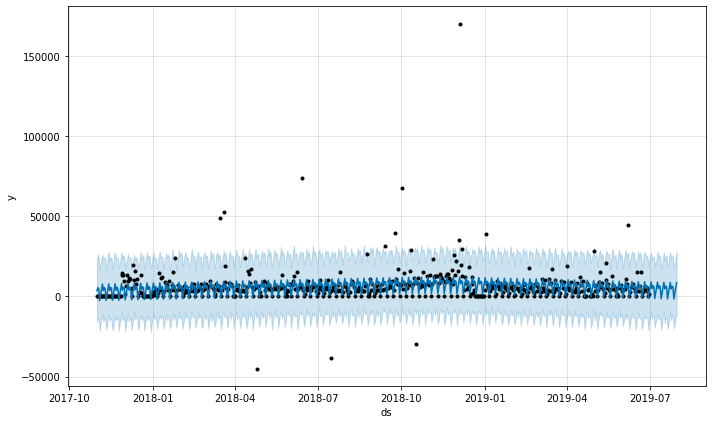

In [189]:
fig1 = model1.plot(forecast)

Plot forecast components using Prophet.plot_components method

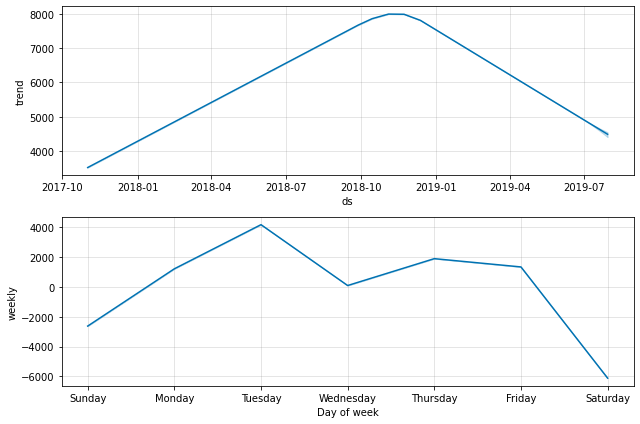

In [190]:
fig2 = model1.plot_components(forecast)

## Diagnostics

I am using time series cross validation to measure forecast error using historical data. Here we do cross-validation to assess prediction performance on a horizon of 60 days, starting with 400 days of training data in the first cutoff and then making predictions every 60 days. On this 607 days time series, this corresponds to 3 total forecasts.

In [260]:
from fbprophet.diagnostics import cross_validation
cutoffs = pd.to_datetime(['2018-12-04', '2019-02-02', '2019-03-04'])
df_cv1 = cross_validation(model1, cutoffs=cutoffs, horizon='90 days')

In [261]:
df_cv1.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-05,15156.147248,941.669797,29556.146461,19956.12,2018-12-04
1,2018-12-06,17778.304836,4912.261549,30798.036687,29325.26,2018-12-04
2,2018-12-07,16668.437665,2466.735601,30647.888069,12825.06,2018-12-04
3,2018-12-08,9238.231653,-4613.114525,23530.155876,0.00,2018-12-04
4,2018-12-09,13357.701114,-774.650763,27468.791159,3966.23,2018-12-04


Compute tatistics of the prediction performance by using performance_metrics utility. The statistics computed are: MSE, RMSE, MAE, MAPE, MDAPE and Coverage.

In [262]:
from fbprophet.diagnostics import performance_metrics
df_p1 = performance_metrics(df_cv1)
df_p1.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,9 days,4.431399e+07,6656.875189,5717.265208,1.299440,1.000000
1,10 days,4.264712e+07,6530.475976,5397.573201,1.140336,1.000000
2,11 days,4.519171e+07,6722.478092,5669.968599,1.301918,1.000000
3,12 days,4.746954e+07,6889.814244,5642.751100,1.462462,0.962963
4,13 days,4.811672e+07,6936.621385,5656.247387,1.462462,0.962963


Visualize cross validation performance metrucs by using plot_cross_validation_metrics

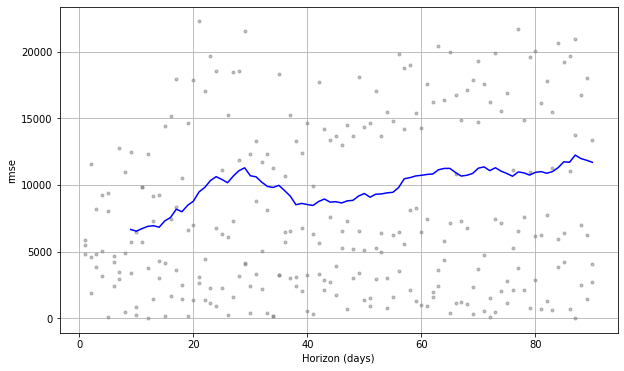

In [263]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv1, metric='rmse')

## Hyperparameter tuning

In [264]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


# Use cross validation to evaluate all parameters
for params in all_params:
    #m = Prophet(**params).fit(df)  # Fit model with given params
    m = Prophet(**params).fit(ts_all_rev)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20D75D710>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20D7C7240>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <co

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01   7165.436809
1                     0.001                     0.10   7196.578168
2                     0.001                     1.00   7205.762553
3                     0.001                    10.00   7203.759414
4                     0.010                     0.01   6716.162290
5                     0.010                     0.10   6662.846383
6                     0.010                     1.00   7128.023316
7                     0.010                    10.00   6803.125445
8                     0.100                     0.01  11575.743146
9                     0.100                     0.10  11609.952920
10                    0.100                     1.00  11642.211493
11                    0.100                    10.00  11738.465452
12                    0.500                     0.01  14258.728031
13                    0.500                     0.10  14351.89

View best parameters

In [265]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


## Repeat above mentioned steps with a new instance of Prophet object with the parameters as mentioned in the code below:

In [266]:
model2=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True,changepoint_prior_scale=2)
model2.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

In [267]:
model2.fit(ts_all_rev)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


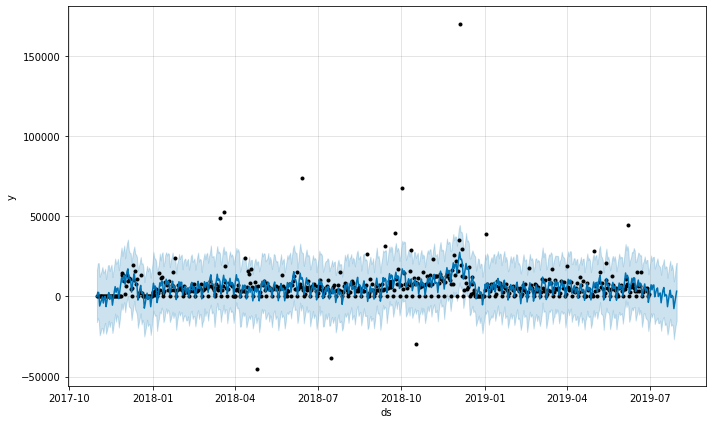

In [268]:
future2 = model2.make_future_dataframe(periods=30)
forecast2 = model2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig2_1 = model2.plot(forecast2)

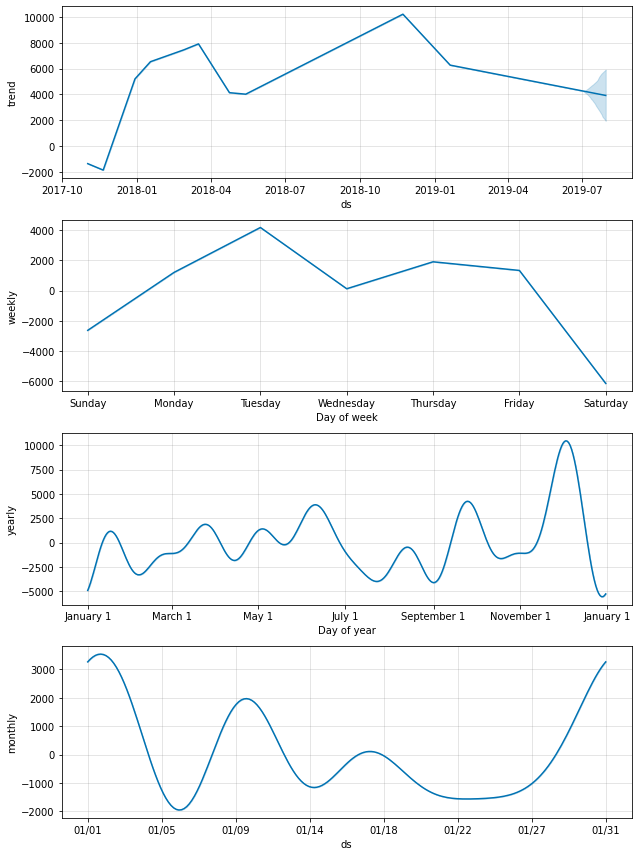

In [269]:
fig2_2 = model2.plot_components(forecast2)

In [270]:
from fbprophet.diagnostics import cross_validation
#cutoffs = pd.to_datetime(['2018-12-30', '2018-07-30', '2019-01-01'])
df_cv2 = cross_validation(model2, cutoffs=cutoffs, horizon='60 days')

In [271]:
df_cv2.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-12-05,59814.878250,40348.321536,78559.566724,19956.12,2018-12-04
1,2018-12-06,66187.615454,46787.394475,86432.066450,29325.26,2018-12-04
2,2018-12-07,68128.911974,49061.277912,86052.071909,12825.06,2018-12-04
3,2018-12-08,63765.081761,44042.089034,81856.935630,0.00,2018-12-04
4,2018-12-09,71822.301778,51953.858058,89681.970985,3966.23,2018-12-04


In [272]:
from fbprophet.diagnostics import performance_metrics
df_p2 = performance_metrics(df_cv2)
df_p2.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,6 days,1.086398e+09,32960.547399,20872.001754,1.520286,0.666667
1,7 days,1.375372e+09,37086.012792,23211.561464,1.236155,0.666667
2,8 days,1.723418e+09,41514.069134,25972.601807,2.299768,0.666667
3,9 days,2.037594e+09,45139.718770,28100.013404,2.254261,0.666667
4,10 days,2.194918e+09,46849.951265,29113.366376,2.254261,0.666667


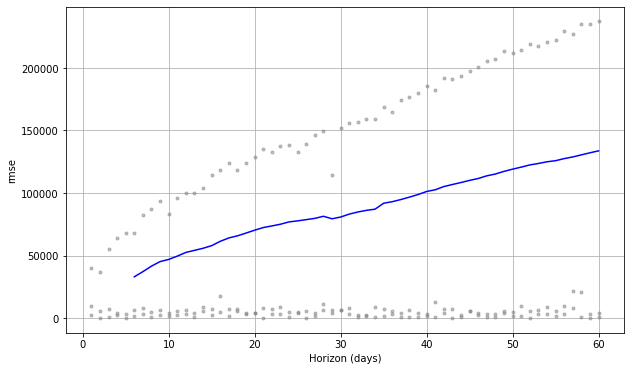

In [274]:
from fbprophet.plot import plot_cross_validation_metric
fig22 = plot_cross_validation_metric(df_cv2, metric='rmse')

In [277]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5,2.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0,20.0],
    'interval_width': [0.40, 0.50, 0.70, 0.80,0.95],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
#cutoffs = pd.to_datetime(['2018-12-30', '2018-07-30', '2019-01-01'])

# Use cross validation to evaluate all parameters
for params in all_params:
    #m = Prophet(**params).fit(df)  # Fit model with given params
    m = Prophet(**params).fit(ts_all_rev)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EC15400>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EFA0588>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <co

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EB20518>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20D859278>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EE6C278>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20B457048>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20D7E4E80>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EAD64A8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20D82C7B8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20D7B06D8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EFA05F8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D20EAD0438>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override 

     changepoint_prior_scale  seasonality_prior_scale  interval_width  \
0                      0.001                     0.01            0.40   
1                      0.001                     0.01            0.50   
2                      0.001                     0.01            0.70   
3                      0.001                     0.01            0.80   
4                      0.001                     0.01            0.95   
..                       ...                      ...             ...   
120                    2.000                    20.00            0.40   
121                    2.000                    20.00            0.50   
122                    2.000                    20.00            0.70   
123                    2.000                    20.00            0.80   
124                    2.000                    20.00            0.95   

             rmse  
0     7134.724620  
1     7134.724620  
2     7134.724620  
3     7134.724620  
4     7134.724620  
.. 

In [278]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'interval_width': 0.4}


In [280]:
model3=Prophet(interval_width=0.4, yearly_seasonality=True, weekly_seasonality=True,changepoint_prior_scale=0.01,seasonality_prior_scale=0.1)
model3.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

In [281]:
model3.fit(ts_all_rev)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


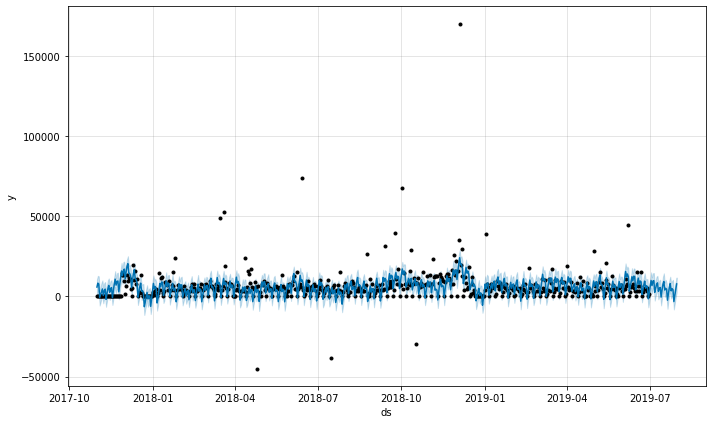

In [282]:
future3 = model3.make_future_dataframe(periods=30)
forecast3 = model3.predict(future2)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig3_1 = model3.plot(forecast3)

In [283]:
df_cv3 = cross_validation(model3, cutoffs=cutoffs, horizon='60 days')

In [284]:
from fbprophet.diagnostics import performance_metrics
df_p3 = performance_metrics(df_cv3)
df_p3.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,6 days,1.372740e+08,11716.398136,9424.446313,1.467047,0.388889
1,7 days,1.626339e+08,12752.801183,9582.346663,1.642444,0.444444
2,8 days,1.993899e+08,14120.548162,10468.030701,1.709320,0.500000
3,9 days,2.240678e+08,14968.895286,10886.205858,2.539961,0.555556
4,10 days,2.114768e+08,14542.241521,11006.530850,1.709320,0.444444


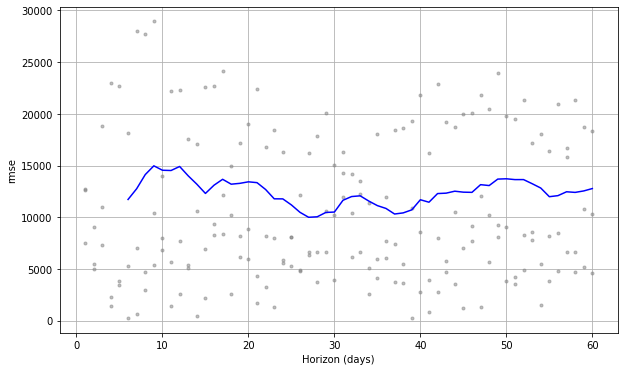

In [285]:
from fbprophet.plot import plot_cross_validation_metric
fig3_3 = plot_cross_validation_metric(df_cv3, metric='rmse')